# FA691 Homework 3
# Due: Wednesday, February 15 @ 11:59PM

Name: Ryan Shea

Date: 2023-02-02

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Set seed of random number generator
CWID = 10445281 #Place here your Campus wide ID number, this will personalize
#your results, but still maintain the reproduceable nature of using seeds.
#If you ever need to reset the seed in this assignment, use this as your seed
#Papers that use -1 as this CWID variable will earn 0's so make sure you change
#this value before you submit your work.
personal = CWID % 10000
np.random.seed(personal)

## Question 1 (10pt)

### Question 1.1
Use the `yfinance` package (or other method of your choice) to obtain the daily adjusted close prices for `SPY` and `IEF`.  You should have at least 5 years of data for both assets. Do **not** include any data after January 1, 2022.  You should inspect the dates for your data to make sure you are including everything appropriately.  Create a binary variable whether the `SPY` returns are above the `IEF` returns on a each day. Create a data frame (or array) of the daily log returns both both stocks along with the lagged returns (at least 2 lags) and your binary class variable.  Use the `print` command to display your data.

In [2]:
import datetime
tickers = ['SPY', 'IEF']
stop = datetime.date(2023, 2, 8)
start = stop - datetime.timedelta(365*5+40) # 5 years, 40 days for buffer

data = yf.download(tickers=tickers, start=start, end=stop)['Adj Close']


df = data.apply(lambda x: np.log(x / x.shift(1))) # log(t / t-1)

df['SPY_ABOVE_IEF'] = (df['SPY'] > df['IEF']).astype(int)

lags = 10

for t in tickers:
    for i in range(1, lags+1):
        df[f"{t}_{i}"] = df[t].shift(i)


df = df.dropna()

print(df.head(), end='\n\n')
print(f"{df.shape = }")


[*********************100%***********************]  2 of 2 completed
                 IEF       SPY  SPY_ABOVE_IEF     SPY_1     SPY_2     SPY_3  \
Date                                                                          
2018-01-18 -0.003166 -0.001682              1  0.009486 -0.003424  0.006498   
2018-01-19 -0.002598  0.004540              1 -0.001682  0.009486 -0.003424   
2018-01-22 -0.000386  0.008098              1  0.004540 -0.001682  0.009486   
2018-01-23  0.002887  0.002120              0  0.008098  0.004540 -0.001682   
2018-01-24 -0.001924 -0.000388              1  0.002120  0.008098  0.004540   

               SPY_4     SPY_5     SPY_6     SPY_7  ...     IEF_1     IEF_2  \
Date                                                ...                       
2018-01-18  0.007270 -0.001531  0.002261  0.001827  ... -0.002201  0.000478   
2018-01-19  0.006498  0.007270 -0.001531  0.002261  ... -0.003166 -0.002201   
2018-01-22 -0.003424  0.006498  0.007270 -0.001531  ... -0.00

### Question 1.2
Split your data into training and testing sets (80% training and 20% test). This split should be done so that the causal relationship is kept consistent (i.e., split data at a specific time).

Run a logistic regression of the binary variable (of `SPY` returns greater than `IEF` returns) as a function of the lagged returns (at least 2 lags) for both stocks.
This should be of the form (assuming 2 lags) of $p_{t} = [1 + \exp(-[\beta_0 + \beta_{SPY,1} r_{SPY,t-1} + \beta_{SPY,2} r_{SPY,t-2} + \beta_{IEF,1} r_{IEF,t-1} + \beta_{IEF,2} r_{IEF,t-2}])]^{-1}$.
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

temp = df.drop(["IEF", "SPY"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(temp.drop("SPY_ABOVE_IEF", axis=1), temp['SPY_ABOVE_IEF'], test_size=0.2)

lr = LogisticRegression()
lr.fit(X_train, y_train)
l_pred = lr.predict(X_test)

print(f"Intercept: {float(lr.intercept_)}", end='\n\n')

for coef, name in zip(lr.coef_[0], X_train.columns):
    print(f" \u03B2 {name:>6}: {coef}")

print()

print(confusion_matrix(y_test, l_pred))
print(f"Score: {accuracy_score(y_test, l_pred)}")



Intercept: 0.16492167921014186

 β  SPY_1: -0.08231192010382934
 β  SPY_2: 0.14003125168721936
 β  SPY_3: 0.16281501357531855
 β  SPY_4: -0.22291642640919737
 β  SPY_5: 0.032440993145706525
 β  SPY_6: -0.3523263202214909
 β  SPY_7: 0.3053225677321785
 β  SPY_8: -0.08793690494411846
 β  SPY_9: 0.40709688145805434
 β SPY_10: -0.1279959054390272
 β  IEF_1: 0.033176543846550374
 β  IEF_2: 0.01101114352522373
 β  IEF_3: -0.004350955551808462
 β  IEF_4: 0.03902488547750795
 β  IEF_5: 0.050195221828548915
 β  IEF_6: 0.007737613773306497
 β  IEF_7: -0.018691900912255453
 β  IEF_8: 0.09720196964699498
 β  IEF_9: -0.2326844298836487
 β IEF_10: 0.10583673012105793

[[  0 110]
 [  0 145]]
Score: 0.5686274509803921


This is not a good model at all, as it is predicting `True` every single time. There is no real learning going on here, it just assumes that the SPY will always outperform IEF.

## Question 2 (30spt)

### Question 2.1
Using the same data, train/test split ratio, and consider the same classification problem as in Question 1.2.
Create a feed-forward neural network with a single hidden layer (10 hidden nodes) densely connected to the inputs.
You may choose any activation functions you wish.

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
import tensorflow as tf

tf.random.set_seed(personal)

model = keras.Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


2023-02-15 22:26:11.167900: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-15 22:26:11.168061: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Question 2.2
Train this neural network on the training data.  
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, verbose=0, validation_split=0.1)

2023-02-15 22:26:11.279625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


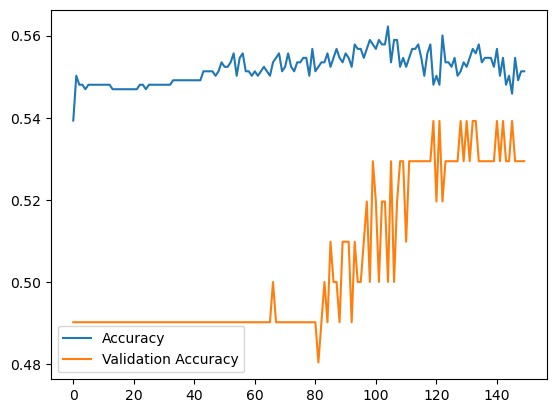



Train Accuracy: 0.5513100624084473
Validation Accuracy: 0.529411792755127
Test Accuracy: 0.5764706134796143

[[ 23  87]
 [ 21 124]]


In [6]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
print(f"\n\nTrain Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

print(f"Test Accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]}", end='\n\n')

model_pred = (model.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, model_pred))

The accuracy is significantly better than the logistic regression, as it is actually making a decision based off the data. It is not always predicting `True` anymore and is getting good test accuracy.

### Question 2.3
Using the same train/test split and consider the same classification problem as in Question 1.2.
Train and test another feed-forward neural network of your own design.

In [7]:
model2 = keras.Sequential()
model2.add(Dense(3, input_shape=(X_train.shape[1],), activation='selu'))
model2.add(Dense(3, activation='relu'))
model2.add(Dense(3, activation='relu'))
model2.add(Dense(3, activation='selu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 63        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [8]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=150, verbose=0, validation_split=0.1, batch_size=32)

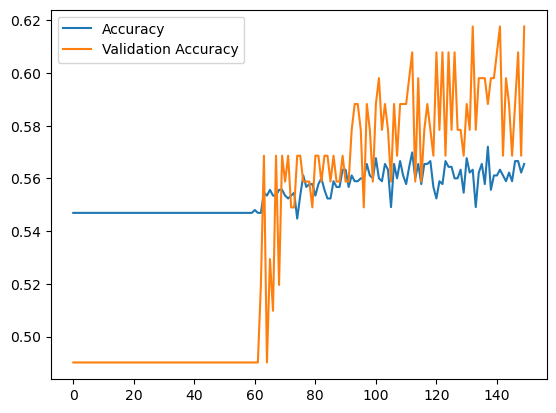



Train Accuracy: 0.5655021667480469
Validation Accuracy: 0.6176470518112183
Test Accuracy: 0.5254902243614197

[[43 67]
 [54 91]]


In [9]:
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
print(f"\n\nTrain Accuracy: {history2.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history2.history['val_accuracy'][-1]}")

print(f"Test Accuracy: {model2.evaluate(X_test, y_test, verbose=0)[1]}", end='\n\n')

model_pred = (model2.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, model_pred))


## Question 3 (30pt)

### Question 3.1
Using the same data, train/test split ratio, and consider the same classification problem as in Question 1.2.
Create a time dilation neural network with a single convolutional layer (filter size of 10, kernel size of 2, dilation size of 1) densely connected to the inputs.
You may choose any activation functions you wish.

*Hint:* The CNN can reference earlier lags on its own without feeding explicit memory inputs as was needed for the Question 2.

In [10]:
model3 = keras.Sequential()
model3.add(keras.layers.Conv1D(filters=10, kernel_size=2, dilation_rate=1, input_shape=(X_train.shape[1], 1)))
model3.add(keras.layers.Flatten())
model3.add(Dense(1, activation='sigmoid'))

model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 10)            30        
_________________________________________________________________
flatten (Flatten)            (None, 190)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 191       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


### Question 3.2
Train this neural network on the training data.
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [11]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train.values.reshape(-1, X_train.shape[1], 1), y_train, epochs=150, verbose=0, validation_split=0.1, batch_size=32)


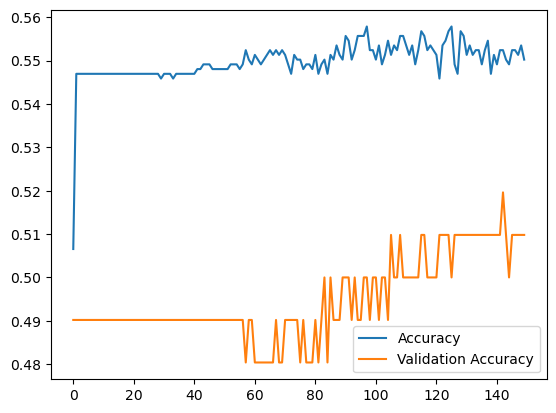



Train Accuracy: 0.5502183437347412
Validation Accuracy: 0.5098039507865906
Test Accuracy: 0.5607843399047852

[[ 14  96]
 [ 16 129]]


In [12]:
plt.plot(history3.history['accuracy'], label='Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
print(f"\n\nTrain Accuracy: {history3.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history3.history['val_accuracy'][-1]}")

print(f"Test Accuracy: {model3.evaluate(X_test.values.reshape(-1, X_test.shape[1], 1), y_test, verbose=0)[1]}", end='\n\n')

model4_pred = (model3.predict(X_test.values.reshape(-1, X_test.shape[1], 1)) > 0.5).astype(int)

print(confusion_matrix(y_test, model4_pred))

### Question 3.3
Using the same train/test split and consider the same classification problem as in Question 1.2. Train and test another convolutional neural network of your own design.

In [13]:
model4 = keras.Sequential()
model4.add(keras.layers.Conv1D(filters=10, kernel_size=2, dilation_rate=1, input_shape=(X_train.shape[1], 1)))
model4.add(keras.layers.Flatten())
model4.add(Dense(10, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 19, 10)            30        
_________________________________________________________________
flatten_1 (Flatten)          (None, 190)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1910      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________


In [14]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history4 = model4.fit(X_train.values.reshape(-1, X_train.shape[1], 1), y_train, epochs=150, verbose=0, validation_split=0.1)

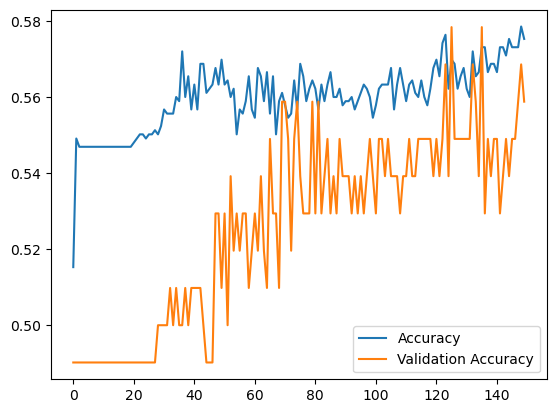



Train Accuracy: 0.5753275156021118
Validation Accuracy: 0.5588235259056091
Test Accuracy: 0.5529412031173706

[[ 31  79]
 [ 35 110]]


In [15]:
plt.plot(history4.history['accuracy'], label='Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
print(f"\n\nTrain Accuracy: {history4.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history4.history['val_accuracy'][-1]}")

print(f"Test Accuracy: {model4.evaluate(X_test.values.reshape(-1, X_test.shape[1], 1), y_test, verbose=0)[1]}", end='\n\n')

model4_pred = (model4.predict(X_test.values.reshape(-1, X_test.shape[1], 1)) > 0.5).astype(int)

print(confusion_matrix(y_test, model4_pred))

## Question 4 (30pt)

## Question 4.1
Consider the same classification problem as in Question 1.2.
Of the methods considered in this assignment, which would you recommend in practice?
Explain briefly (1 paragraph) why you choose this fit. 

The "base case" Logistic regression does not necessarily bring anything of value, as it is literally *always* predicting SPY to outperform IEF. This strategy would be to obviously buy and hold SPY for the end of time.

In terms of accuracy, the most simple feed-forward model whas the highest accuracy at over 57%, and it is not overfitting either. In fact, the test accuracy was even higher than the train.

The second CNN had roughly the same accuracy, but that could be because it is predicting True at a significantly higher rate than the other, so that could be moreso just luck as there are a lot more Trues than Falses in the test set. Therefore, I would choose the feed-forward model with 3 nodes at each hidden layer.

## Question 4.2
Recreate your data set using data from January 1, 2022 through December 31, 2022.
Using the method your would implement in practice, invest in the asset (``SPY`` or ``IEF``) depending on your predictions.
Print the returns your portfolio would obtain from following this strategy. Comment on how this portfolio compares with the ``SPY`` and ``IEF`` returns and risks.

First, I will use buy-and-hold SPY as the base case to compare the strategy to.

In [16]:
data = yf.download(tickers=tickers, start='2022-01-01', end='2022-12-31')['Adj Close']


ret = data.apply(lambda x: np.log(x / x.shift(1))) # log returns

lags = 10

for t in tickers:
    for i in range(1, lags+1):
        ret[f"{t}_{i}"] = ret[t].shift(i)


ret = ret.dropna()

print(ret.head(), end='\n\n')
print(f"{ret.shape = }")

[*********************100%***********************]  2 of 2 completed
                 IEF       SPY     SPY_1     SPY_2     SPY_3     SPY_4  \
Date                                                                     
2022-01-19  0.002414 -0.010438 -0.017868  0.000409 -0.013874  0.002700   
2022-01-20  0.002141 -0.011130 -0.010438 -0.017868  0.000409 -0.013874   
2022-01-21  0.005774 -0.019826 -0.011130 -0.010438 -0.017868  0.000409   
2022-01-24 -0.000886  0.004238 -0.019826 -0.011130 -0.010438 -0.017868   
2022-01-25 -0.001331 -0.012284  0.004238 -0.019826 -0.011130 -0.010438   

               SPY_5     SPY_6     SPY_7     SPY_8  ...     IEF_1     IEF_2  \
Date                                                ...                       
2022-01-19  0.009067 -0.001245 -0.003961 -0.000940  ... -0.007579 -0.006905   
2022-01-20  0.002700  0.009067 -0.001245 -0.003961  ...  0.002414 -0.007579   
2022-01-21 -0.013874  0.002700  0.009067 -0.001245  ...  0.002141  0.002414   
2022-01-24  0.000

In [17]:
# Calculate cumluative returns of df['SPY']
spy_returns = np.zeros(len(ret['SPY'])+1)
spy_returns[0] = 1
for i in range(1, len(ret['SPY'])+1):
    spy_returns[i] = spy_returns[i-1] * (1 + ret['SPY'][i-1])

spy = spy_returns[-1] - 1
print(f"SPY Returns over the period: {spy}")


SPY Returns over the period: -0.17282694235256402


In [18]:
test_data = ret.drop(columns=['SPY', 'IEF'])

predictions = (model.predict(test_data) > 0.5).astype(int).flatten()
predictions


array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

In [19]:
model_algo_daily_ret = np.zeros(len(ret['SPY']))

for i in range(len(model_algo_daily_ret)):
    if predictions[i] == 1:
        model_algo_daily_ret[i] = ret['SPY'][i]
    else:
        model_algo_daily_ret[i] = ret['IEF'][i]

model_algo_cum_ret = np.zeros(len(model_algo_daily_ret)+1)
model_algo_cum_ret[0] = 1
for i in range(1, len(model_algo_daily_ret)+1):
    model_algo_cum_ret[i] = model_algo_cum_ret[i-1] * (1 + model_algo_daily_ret[i-1])

model_algo = model_algo_cum_ret[-1] - 1

print(f"Model Algo Returns over the period:         {model_algo}")

print(f"Difference compared to SPY (+ good, - bad): {model_algo - spy}", end='\n\n')

print(f"SPY std:        {ret['SPY'].std() * np.sqrt(252)}")
print(f"Model Algo std: {np.std(model_algo_daily_ret) * np.sqrt(252)}", end='\n\n')

print(f"SPY Sharpe:        {(ret['SPY'].mean() * 252) / (ret['SPY'].std() * np.sqrt(252))}")
print(f"Model Algo Sharpe: {(model_algo_daily_ret.mean() * 252) / (np.std(model_algo_daily_ret) * np.sqrt(252))}")


Model Algo Returns over the period:         -0.20946032861328945
Difference compared to SPY (+ good, - bad): -0.03663338626072543

SPY std:        0.24602843730869683
Model Algo std: 0.2261954165082829

SPY Sharpe:        -0.686808437379032
Model Algo Sharpe: -0.9771674907234906


You can see that the model underperformed the SPY by roughly 3%. It does come at a slightly lower volatility which makes sense as IEF has a lower vol. In terms of Sharpe Ratio, they are both negative, with the algo doing still worse. Therefore, it is not a good strategy to use and you are going to make more money by holding SPY over 2022.